In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [2]:
import tensorflow as tf,matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize,rescale
from skimage import measure, segmentation,morphology,filters,feature,exposure
import tifffile
import momia2 as mo
from momia2.classify.classifier_helper import *
import timeit
import pickle as pk
from tensorflow import keras
from unet import *
import glob, os
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from matplotlib import cm
from microfilm.microplot import microshow

In [15]:
ref = pd.read_excel('/Volumes/JZSSD_temp/202212_Harry_flow/20221220_mero_batch/microscopy-key.xlsx')
wells = ref['Well'].values.copy()
ref['Well'] = [w[0]+w[1:].zfill(2) for w in wells]
ref = ref.set_index('Well')

In [42]:
# load flow data
flow_data = pd.read_csv('/Volumes/JZSSD_temp/202212_Harry_flow/filtered_csv.csv')
flow_grouped = pk.load(open('/Volumes/JZSSD_temp/202212_Harry_flow/filtered_grouped.pk','rb'))

In [19]:
# load_microscopy_data 
microscopy_data = []
for f in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_flow/20221220_mero_batch/*/')):
    well = f.split('/')[-2]
    strain,target,rapa = ref.loc[well,['Strain','Target','Rapa']].values
    for s in sorted(glob.glob(f+'*.pk')):
        patch = pk.load(open(s,'rb'))
        patch_header = s.split('/')[-1].split('.')[0]
        patch.regionprops['Image_header'] = patch_header
        patch.regionprops['Strain'] = strain
        patch.regionprops['Target'] = target
        patch.regionprops['Rapa'] = rapa
        patch.regionprops['Well'] = well
        patch.regionprops['Unique_key'] = '{}_{}'.format(target,rapa)
        microscopy_data.append(patch.regionprops)
microscopy_data=pd.concat(microscopy_data)

In [41]:
microscopy_grouped = microscopy_data.groupby('Unique_key').median()

In [46]:
flow_t3 = flow_grouped[flow_grouped['Time']=='t3'].copy()
flow_t3['Unique_key'] = ['{}_{}'.format(a,b) for a,b in flow_t3[['Substrate','Rapamycin']].values]
flow_regrouped = flow_t3.groupby('Unique_key').median()

In [68]:
shared_id = np.array(list(set(flow_regrouped.index) & set(microscopy_grouped.index)))

In [104]:
overlay = pd.DataFrame({'Substrate':[x.split('_')[0] for x in shared_id],
                        'Rapamycin':[x.split('_')[1] for x in shared_id],
                        'Flow_intensity':flow_regrouped.loc[shared_id]['B1-H'].values,
                        'Microscopy_intensity (log2-transformed)':np.log2(microscopy_grouped.loc[shared_id]['FITC_mean'].values-450)})

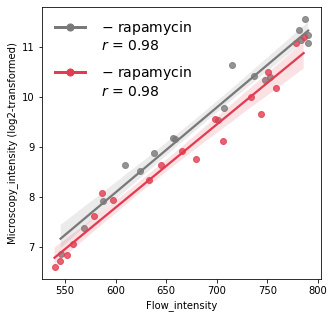

In [140]:
from scipy.stats import pearsonr
ctrl_color=np.array([121,121,121])/255
rapa_color=np.array([225,60,80])/255

fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot()
sns.regplot(data=overlay[overlay['Rapamycin']=='-'],x='Flow_intensity',y='Microscopy_intensity (log2-transformed)',color=ctrl_color,ax=ax)
sns.regplot(data=overlay[overlay['Rapamycin']=='+'],x='Flow_intensity',y='Microscopy_intensity (log2-transformed)',color=rapa_color,ax=ax)
ax.plot([540,570],[11.4,11.4],lw=3,color=ctrl_color)
ax.scatter(555,11.4,color=ctrl_color,s=50)
ax.plot([540,570],[10.5,10.5],lw=3,color=rapa_color)
ax.scatter(555,10.5,color=rapa_color,s=50)

ax.text(585,11.55,'$-$ rapamycin\n$r$ = {}'.format(round(pearsonr(overlay[overlay['Rapamycin']=='-']['Flow_intensity'],
                                                                  overlay[overlay['Rapamycin']=='-']['Microscopy_intensity (log2-transformed)'])[0],2))
        ,va='top',fontsize=14)
ax.text(585,10.65,'$-$ rapamycin\n$r$ = {}'.format(round(pearsonr(overlay[overlay['Rapamycin']=='+']['Flow_intensity'],
                                                                  overlay[overlay['Rapamycin']=='+']['Microscopy_intensity (log2-transformed)'])[0],2))
        ,va='top',fontsize=14)
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_flow/flow_microscopy_corr.svg',bbox_inches='tight')